# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

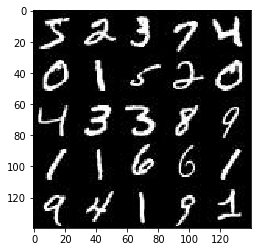

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

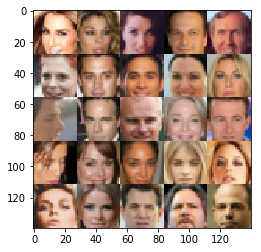

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='input_z')
    l_r = tf.placeholder(tf.float32, name='l_r')

    return input_real, input_z, l_r


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.05
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
#         print(images.shape)
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        crelu1 = tf.maximum(alpha * conv1, conv1)
#         print(crelu1.shape)
        
        conv2 = tf.layers.conv2d(crelu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        crelu2 = tf.maximum(alpha * bn2, bn2)
#         print(crelu2.shape)
        
        conv3 = tf.layers.conv2d(crelu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        crelu3 = tf.maximum(alpha * bn3, bn3)
#         print(crelu3.shape)
        
        flat = tf.reshape(crelu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
#         print(logits.shape)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.05
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        reshape1 = tf.reshape(x1, (-1, 7, 7, 256))
        crelu1 = tf.maximum(alpha * reshape1, reshape1)
        # 7x7x256
#         print(crelu1.shape)

        conv2 = tf.layers.conv2d_transpose(crelu1, 128, 5, strides=2, padding="same")
        bn2 = tf.layers.batch_normalization(conv2, training=is_train)
        crelu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x128
#         print(crelu2.shape)
        
        conv3 = tf.layers.conv2d_transpose(crelu2, 64, 5, strides=2, padding="same")
        bn3 = tf.layers.batch_normalization(conv3, training=is_train)
        crelu3 = tf.maximum(alpha * bn3, bn3)
        # 28x28x64
#         print(crelu3.shape)

        conv4 = tf.layers.conv2d_transpose(crelu3, 32, 5, strides=1, padding="same")
        bn4 = tf.layers.batch_normalization(conv4, training=is_train)
        crelu4 = tf.maximum(alpha * bn4, bn4)
        
        logits = tf.layers.conv2d_transpose(crelu4, out_channel_dim, 5, strides=1, padding="same")
        # 28x28xout_dim
#         print(logits.shape)
#         print(out_channel_dim)

    return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth))
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))
    )
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake))
    )
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    _, image_width, image_height, image_channels = data_shape
        
    input_real, input_z, l_r = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
  
    
    # TODO: Build Model
    saver = tf.train.Saver()
    steps = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps +=1
                
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                
                if steps % 100 == 0:
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)
                    
        show_generator_output(sess, 5, input_z, image_channels, data_image_mode)        
        saver.save(sess, './checkpoints/generator.ckpt')        
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2093... Generator Loss: 3.9605
Epoch 1/2... Discriminator Loss: 3.0171... Generator Loss: 5.3911
Epoch 1/2... Discriminator Loss: 0.8224... Generator Loss: 2.5434
Epoch 1/2... Discriminator Loss: 1.1400... Generator Loss: 2.0690
Epoch 1/2... Discriminator Loss: 1.1358... Generator Loss: 2.0608
Epoch 1/2... Discriminator Loss: 1.0979... Generator Loss: 1.4584
Epoch 1/2... Discriminator Loss: 1.3185... Generator Loss: 1.7987
Epoch 1/2... Discriminator Loss: 1.5243... Generator Loss: 1.8332
Epoch 1/2... Discriminator Loss: 1.1609... Generator Loss: 1.4615
Epoch 1/2... Discriminator Loss: 1.2559... Generator Loss: 1.7708


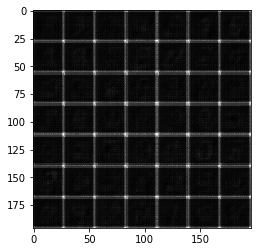

Epoch 1/2... Discriminator Loss: 1.1384... Generator Loss: 1.1731
Epoch 1/2... Discriminator Loss: 1.1355... Generator Loss: 1.6879
Epoch 1/2... Discriminator Loss: 1.1170... Generator Loss: 1.8843
Epoch 1/2... Discriminator Loss: 1.2606... Generator Loss: 2.1758
Epoch 1/2... Discriminator Loss: 1.0286... Generator Loss: 1.8795
Epoch 1/2... Discriminator Loss: 0.9089... Generator Loss: 1.4100
Epoch 1/2... Discriminator Loss: 1.0336... Generator Loss: 2.0169
Epoch 1/2... Discriminator Loss: 0.9293... Generator Loss: 1.3699
Epoch 1/2... Discriminator Loss: 1.1993... Generator Loss: 2.1347
Epoch 1/2... Discriminator Loss: 1.0371... Generator Loss: 0.8687


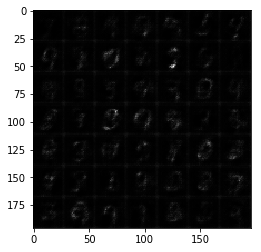

Epoch 1/2... Discriminator Loss: 1.5499... Generator Loss: 0.4318
Epoch 1/2... Discriminator Loss: 0.9373... Generator Loss: 1.2415
Epoch 1/2... Discriminator Loss: 1.0617... Generator Loss: 1.2486
Epoch 1/2... Discriminator Loss: 1.4799... Generator Loss: 2.6576
Epoch 1/2... Discriminator Loss: 0.9864... Generator Loss: 0.9342
Epoch 1/2... Discriminator Loss: 0.9952... Generator Loss: 1.7807
Epoch 1/2... Discriminator Loss: 1.2870... Generator Loss: 2.4705
Epoch 1/2... Discriminator Loss: 0.9850... Generator Loss: 1.0824
Epoch 1/2... Discriminator Loss: 1.8952... Generator Loss: 0.2832
Epoch 1/2... Discriminator Loss: 1.2991... Generator Loss: 0.5728


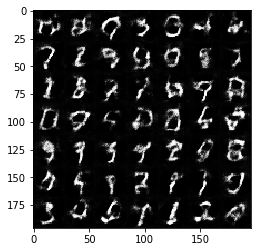

Epoch 1/2... Discriminator Loss: 1.6280... Generator Loss: 0.4083
Epoch 1/2... Discriminator Loss: 0.8925... Generator Loss: 1.1435
Epoch 1/2... Discriminator Loss: 1.1019... Generator Loss: 0.8017
Epoch 1/2... Discriminator Loss: 1.2272... Generator Loss: 0.6429
Epoch 1/2... Discriminator Loss: 1.0113... Generator Loss: 0.9842
Epoch 1/2... Discriminator Loss: 1.7514... Generator Loss: 0.3610
Epoch 1/2... Discriminator Loss: 1.2399... Generator Loss: 0.6561
Epoch 1/2... Discriminator Loss: 1.5050... Generator Loss: 0.4492
Epoch 1/2... Discriminator Loss: 1.0501... Generator Loss: 0.8754
Epoch 1/2... Discriminator Loss: 1.4376... Generator Loss: 0.5130


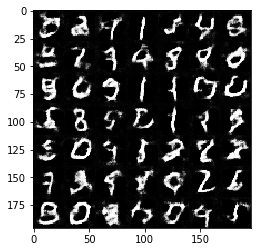

Epoch 1/2... Discriminator Loss: 1.2518... Generator Loss: 0.6067
Epoch 1/2... Discriminator Loss: 1.2445... Generator Loss: 0.6439
Epoch 1/2... Discriminator Loss: 1.2653... Generator Loss: 0.6431
Epoch 1/2... Discriminator Loss: 1.0822... Generator Loss: 0.9473
Epoch 1/2... Discriminator Loss: 1.1025... Generator Loss: 0.7682
Epoch 1/2... Discriminator Loss: 1.2473... Generator Loss: 0.7120
Epoch 2/2... Discriminator Loss: 1.1667... Generator Loss: 0.6848
Epoch 2/2... Discriminator Loss: 1.0507... Generator Loss: 0.8876
Epoch 2/2... Discriminator Loss: 1.1231... Generator Loss: 0.7787
Epoch 2/2... Discriminator Loss: 1.1070... Generator Loss: 0.8184


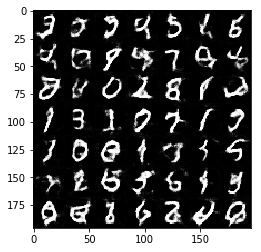

Epoch 2/2... Discriminator Loss: 1.2897... Generator Loss: 0.6040
Epoch 2/2... Discriminator Loss: 1.0145... Generator Loss: 0.9392
Epoch 2/2... Discriminator Loss: 1.2047... Generator Loss: 1.8375
Epoch 2/2... Discriminator Loss: 1.0053... Generator Loss: 1.4096
Epoch 2/2... Discriminator Loss: 0.9883... Generator Loss: 1.1726
Epoch 2/2... Discriminator Loss: 1.0089... Generator Loss: 1.2300
Epoch 2/2... Discriminator Loss: 1.2920... Generator Loss: 0.6352
Epoch 2/2... Discriminator Loss: 1.3465... Generator Loss: 0.5798
Epoch 2/2... Discriminator Loss: 1.0313... Generator Loss: 0.9794
Epoch 2/2... Discriminator Loss: 1.6049... Generator Loss: 0.4232


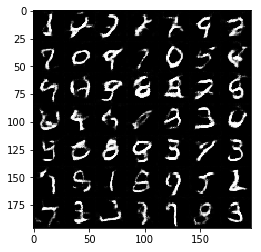

Epoch 2/2... Discriminator Loss: 1.3078... Generator Loss: 0.5997
Epoch 2/2... Discriminator Loss: 1.0432... Generator Loss: 0.8474
Epoch 2/2... Discriminator Loss: 1.6760... Generator Loss: 0.4133
Epoch 2/2... Discriminator Loss: 0.9813... Generator Loss: 1.2588
Epoch 2/2... Discriminator Loss: 0.9654... Generator Loss: 0.9964
Epoch 2/2... Discriminator Loss: 1.2368... Generator Loss: 0.6319
Epoch 2/2... Discriminator Loss: 1.1384... Generator Loss: 0.7385
Epoch 2/2... Discriminator Loss: 1.4137... Generator Loss: 0.5691
Epoch 2/2... Discriminator Loss: 1.0108... Generator Loss: 1.2545
Epoch 2/2... Discriminator Loss: 1.3325... Generator Loss: 2.2120


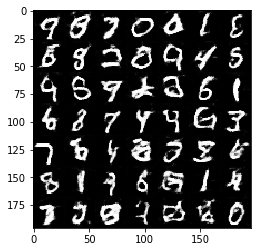

Epoch 2/2... Discriminator Loss: 1.0154... Generator Loss: 1.1867
Epoch 2/2... Discriminator Loss: 0.9201... Generator Loss: 1.4586
Epoch 2/2... Discriminator Loss: 1.9326... Generator Loss: 2.5985
Epoch 2/2... Discriminator Loss: 1.0689... Generator Loss: 1.0350
Epoch 2/2... Discriminator Loss: 1.2473... Generator Loss: 0.6240
Epoch 2/2... Discriminator Loss: 1.3648... Generator Loss: 0.5583
Epoch 2/2... Discriminator Loss: 1.2901... Generator Loss: 0.6239
Epoch 2/2... Discriminator Loss: 1.0475... Generator Loss: 0.9590
Epoch 2/2... Discriminator Loss: 1.0173... Generator Loss: 0.9473
Epoch 2/2... Discriminator Loss: 1.1444... Generator Loss: 0.7911


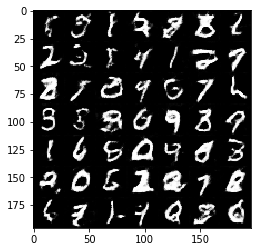

Epoch 2/2... Discriminator Loss: 1.0366... Generator Loss: 0.9121
Epoch 2/2... Discriminator Loss: 1.3443... Generator Loss: 0.5897
Epoch 2/2... Discriminator Loss: 1.3182... Generator Loss: 0.5618
Epoch 2/2... Discriminator Loss: 1.1464... Generator Loss: 0.8314
Epoch 2/2... Discriminator Loss: 1.1055... Generator Loss: 1.5993
Epoch 2/2... Discriminator Loss: 1.0111... Generator Loss: 1.4097
Epoch 2/2... Discriminator Loss: 0.9497... Generator Loss: 1.0996
Epoch 2/2... Discriminator Loss: 1.4476... Generator Loss: 0.5144
Epoch 2/2... Discriminator Loss: 1.3432... Generator Loss: 0.6223
Epoch 2/2... Discriminator Loss: 1.0200... Generator Loss: 1.1936


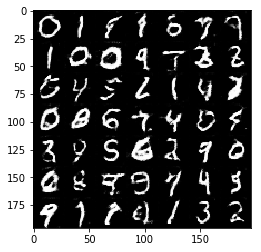

Epoch 2/2... Discriminator Loss: 1.8833... Generator Loss: 2.8138
Epoch 2/2... Discriminator Loss: 0.9450... Generator Loss: 1.1709
Epoch 2/2... Discriminator Loss: 0.8042... Generator Loss: 1.2513


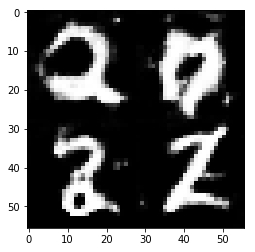

In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

tf.reset_default_graph()

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 0.4430... Generator Loss: 3.8967
Epoch 1/1... Discriminator Loss: 0.6069... Generator Loss: 2.1387
Epoch 1/1... Discriminator Loss: 0.5793... Generator Loss: 4.2836
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 1.1393
Epoch 1/1... Discriminator Loss: 1.7195... Generator Loss: 0.4531
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.5034


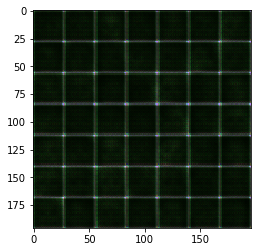

Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 1.5721... Generator Loss: 0.4288
Epoch 1/1... Discriminator Loss: 0.7033... Generator Loss: 2.5092
Epoch 1/1... Discriminator Loss: 0.9748... Generator Loss: 0.9388
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 0.6270... Generator Loss: 2.3295
Epoch 1/1... Discriminator Loss: 0.7930... Generator Loss: 1.1703


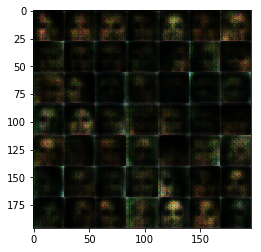

Epoch 1/1... Discriminator Loss: 1.6874... Generator Loss: 0.4237
Epoch 1/1... Discriminator Loss: 0.9231... Generator Loss: 2.8900
Epoch 1/1... Discriminator Loss: 0.6659... Generator Loss: 2.2260
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 4.2675
Epoch 1/1... Discriminator Loss: 0.6033... Generator Loss: 3.8790
Epoch 1/1... Discriminator Loss: 0.8197... Generator Loss: 1.2287
Epoch 1/1... Discriminator Loss: 0.5576... Generator Loss: 2.6653
Epoch 1/1... Discriminator Loss: 0.6972... Generator Loss: 2.4670
Epoch 1/1... Discriminator Loss: 0.8082... Generator Loss: 2.6994
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 2.8951


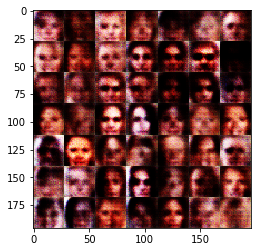

Epoch 1/1... Discriminator Loss: 0.7130... Generator Loss: 2.7264
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 1.7134
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 0.7533... Generator Loss: 1.9066
Epoch 1/1... Discriminator Loss: 0.7570... Generator Loss: 2.1021
Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 2.3271
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 2.5597
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 2.3142
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 2.3441
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 2.6707


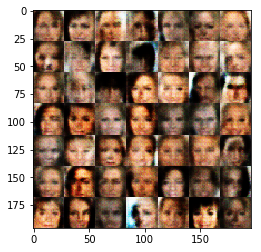

Epoch 1/1... Discriminator Loss: 0.7473... Generator Loss: 1.8498
Epoch 1/1... Discriminator Loss: 0.8281... Generator Loss: 2.0513
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 1.8813
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 2.1452
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 2.4538
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 2.4044
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 2.6218
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 3.3283
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.6089


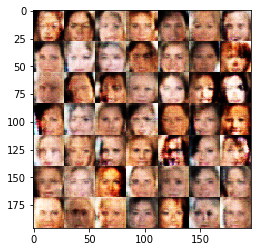

Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.4949
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.4626
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.4846
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 1.5029... Generator Loss: 0.4215
Epoch 1/1... Discriminator Loss: 1.7305... Generator Loss: 0.3401
Epoch 1/1... Discriminator Loss: 0.7912... Generator Loss: 2.5171
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 2.0020
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 2.5826


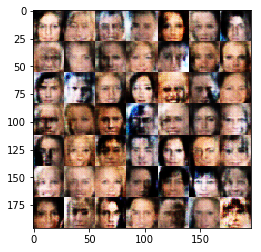

Epoch 1/1... Discriminator Loss: 1.7468... Generator Loss: 3.0432
Epoch 1/1... Discriminator Loss: 0.6705... Generator Loss: 1.8822
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 2.4017
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 4.3871
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 2.6308
Epoch 1/1... Discriminator Loss: 0.6560... Generator Loss: 1.7150
Epoch 1/1... Discriminator Loss: 0.9321... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 0.5383... Generator Loss: 3.3782
Epoch 1/1... Discriminator Loss: 2.3540... Generator Loss: 3.9485


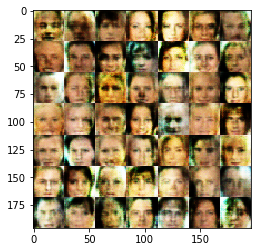

Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 2.3518
Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 4.1337
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 2.5059
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 3.3069
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 1.7054
Epoch 1/1... Discriminator Loss: 0.7525... Generator Loss: 1.2377
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.4654
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 0.6649


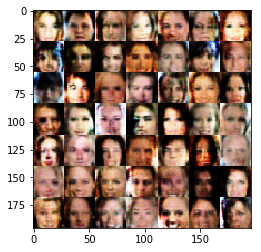

Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.9232... Generator Loss: 0.2708
Epoch 1/1... Discriminator Loss: 0.9140... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.4394
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.5158
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.5394
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.5553
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 0.6286


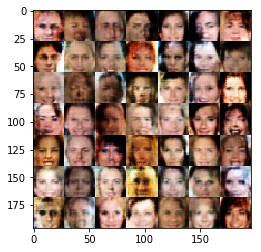

Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 1.0934
Epoch 1/1... Discriminator Loss: 1.5788... Generator Loss: 0.4039
Epoch 1/1... Discriminator Loss: 0.7645... Generator Loss: 1.7529
Epoch 1/1... Discriminator Loss: 0.6749... Generator Loss: 1.5447
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 0.9402... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 1.1123
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 0.7943... Generator Loss: 1.2522
Epoch 1/1... Discriminator Loss: 0.6115... Generator Loss: 2.0114


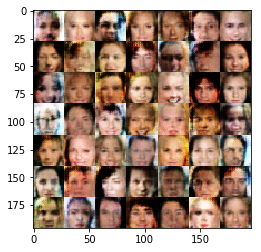

Epoch 1/1... Discriminator Loss: 2.4326... Generator Loss: 3.5531
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 1.9906
Epoch 1/1... Discriminator Loss: 0.6223... Generator Loss: 2.9498
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 1.8053
Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 1.4728
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.5098
Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 0.6248... Generator Loss: 1.5901
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 1.0408


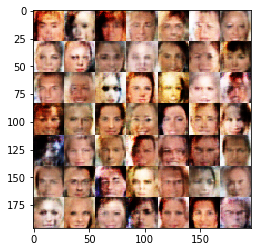

Epoch 1/1... Discriminator Loss: 0.6697... Generator Loss: 1.8056
Epoch 1/1... Discriminator Loss: 0.7117... Generator Loss: 1.7743
Epoch 1/1... Discriminator Loss: 1.9779... Generator Loss: 4.5990
Epoch 1/1... Discriminator Loss: 0.6773... Generator Loss: 2.2233
Epoch 1/1... Discriminator Loss: 0.7002... Generator Loss: 2.3219
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 2.7799
Epoch 1/1... Discriminator Loss: 0.7018... Generator Loss: 3.2334
Epoch 1/1... Discriminator Loss: 0.6922... Generator Loss: 3.2153
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 2.8311
Epoch 1/1... Discriminator Loss: 0.7317... Generator Loss: 2.0088


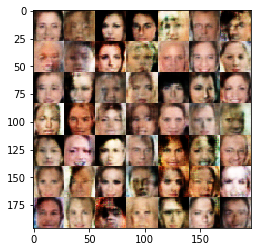

Epoch 1/1... Discriminator Loss: 1.9375... Generator Loss: 0.2652
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.5534
Epoch 1/1... Discriminator Loss: 0.5924... Generator Loss: 1.9234
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 1.8587
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 1.6453... Generator Loss: 0.3570
Epoch 1/1... Discriminator Loss: 0.6363... Generator Loss: 1.6873
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 2.6511


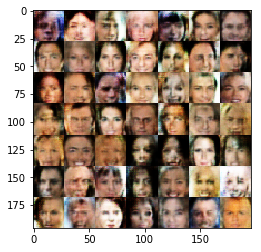

Epoch 1/1... Discriminator Loss: 0.8318... Generator Loss: 1.7511
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 2.9235
Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 1.0466
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 1.6220... Generator Loss: 0.3863
Epoch 1/1... Discriminator Loss: 0.9517... Generator Loss: 1.0763
Epoch 1/1... Discriminator Loss: 0.8546... Generator Loss: 1.4960
Epoch 1/1... Discriminator Loss: 1.6019... Generator Loss: 0.3778


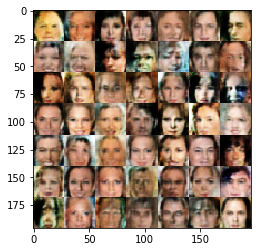

Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 1.0018
Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 2.0590
Epoch 1/1... Discriminator Loss: 0.6736... Generator Loss: 1.6780
Epoch 1/1... Discriminator Loss: 1.7639... Generator Loss: 2.1592
Epoch 1/1... Discriminator Loss: 0.8293... Generator Loss: 1.9902
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 1.0086
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 1.1001
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.4616
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 1.7328


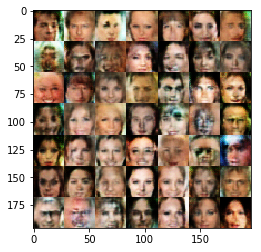

Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 1.4855
Epoch 1/1... Discriminator Loss: 0.9184... Generator Loss: 1.6175
Epoch 1/1... Discriminator Loss: 0.8677... Generator Loss: 1.2729
Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 1.6673
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 1.9690


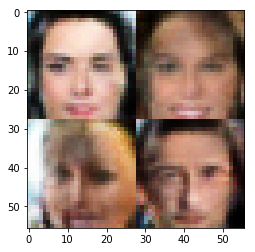

In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.